# Digital, Asian and barrier options

In this notebook we want to study the problem of pricing exotic derivatives by solving their associated PDE.

I will use the same framework, based on the implicit discretization, presented in the Black-Scholes PDE notebook.
The results are then compared with the values obtained from Monte Carlo methods and closed formulas.

## Contents
   - [Digital/Binary options](#sec1)
      - [Derivation](#sec1.1)
      - [Numerical solution](#sec1.2)
   - [Asian options](#sec2)
      - [Derivation](#sec2.1)
      - [Numerical solution](#sec2.2)
   - [Barrier options](#sec3)
      - [Derivation](#sec3.1)
      - [Numerical solution](#sec3.2)

In [1]:
from functions.BS_pricer import BS_pricer
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

In [2]:
# Option variables
S0=100.0; K=100.0; T=1.0; r=0.1; sig=0.2; X0 = np.log(S0)

<a id='sec1'></a>
## Binary/digital options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Binary_option)

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E} \bigl[ \mathbb{1}_{\{S_T > K\}} \, \big| \, S_t=s \bigr]
\end{equation}


<a id='sec1.1'></a>
## Derivation



<a id='sec1.2'></a>
## Numerical solution

In [3]:
# Closed formula
d2 = (np.log(S0/K) + (r - sig**2 / 2) * T) / (sig * np.sqrt(T))
N2 = ss.norm.cdf(d2)
closed_digital = np.exp(-r*T) * N2
print("The price of the ATM digital option by closed formula is: ", closed_digital)

The price of the ATM digital option by closed formula is:  0.5930501164033175


In [4]:
# Monte Carlo
np.random.seed(seed=42)
N_simulation = 20000000
W = (r - sig**2/2)*T  + ss.norm.rvs(loc=0, scale=sig, size=N_simulation)
S_T = S0 * np.exp(W)

MC_digital = np.exp(-r*T) * scp.mean( S_T > K )
print("The price of the ATM digital option by Monte Carlo is: ", MC_digital)

The price of the ATM digital option by Monte Carlo is:  0.593071342432063


In [5]:
# PDE
Nspace = 6000   # M space steps
Ntime = 5000    # N time steps   
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.where(np.exp(x)>K, 1, 0)          # Binary payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 1                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the ATM digital option by PDE is: ", oPrice)

The price of the ATM digital option by PDE is:  0.5930454651650973


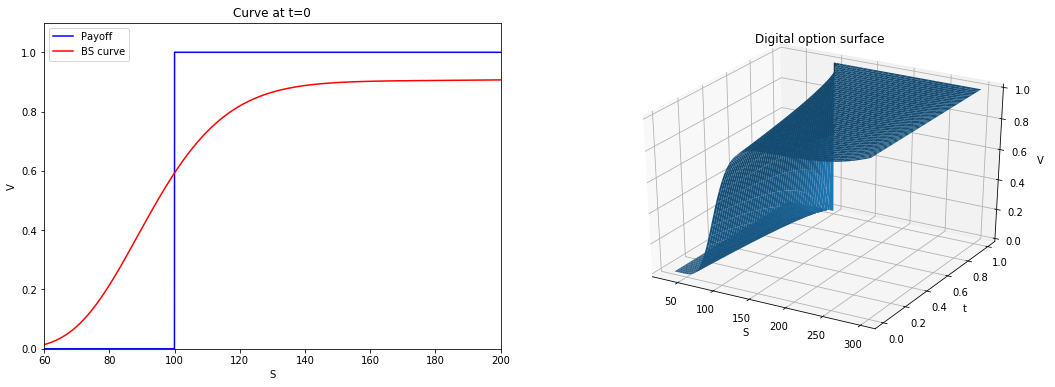

In [21]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="BS curve")
ax1.set_xlim(60,200); ax1.set_ylim(0,1.1)
ax1.set_xlabel("S"); ax1.set_ylabel("V"); ax1.legend(loc='upper left')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
plt.show()

<a id='sec2'></a>
## Asian options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Asian_option)

<a id='sec2.1'></a>
## Derivation

<a id='sec2.2'></a>
## Numerical solution

<a id='sec3'></a>
## Barrier options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Barrier_option)

<a id='sec3.1'></a>
## Derivation

<a id='sec3.2'></a>
## Numerical solution

### References

[1]  Daniel Sevcovic, Beata Stehlikova, Karol Mikula (2011). Analytical and numerical methods for pricing financial derivatives. Nova Science Pub Inc; UK. 

[2] Wilmott Paul (1994). Option pricing: Mathematical models and computation. Oxford Financial Press